In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# READ CSV WITH IMAGE PATHS

train_ds = pd.read_csv("../Dataset/Augmented/labels_train.csv", index_col=0)
train_ds.head()

,Image path,Class,Weight
0,cacao-0.jpg,FBO1,1.66
1,cacao-1.jpg,FBO1,1.66
2,cacao-2.jpg,FBO1,1.66
3,cacao-3.jpg,FBO1,1.66
4,cacao-4.jpg,FBO1,1.66


In [3]:
from scipy.ndimage import binary_fill_holes
from skimage.morphology import remove_small_objects
from skimage.measure import regionprops
from skimage.measure import label
from skimage.feature import graycomatrix, graycoprops
from scipy import stats

def extract_attributes(image):
    
    # Resize once and convert to grayscale
    image_resized = cv2.resize(image, (500, 300))
    image_gray = cv2.cvtColor(image_resized, cv2.COLOR_RGB2GRAY)

    # Thresholding and hole filling
    _, img = cv2.threshold(image_gray, 0, 1, cv2.THRESH_OTSU)
    img = 1 - img
    img = binary_fill_holes(img)

    # Calculate largest bounding box using regionprops
    lab, num = label(img, return_num=True)
    max_area = 0
    bbox = []

    for i in range(1, num + 1):
        object_region = (lab == i).astype('uint8')
        prop = regionprops(object_region)[0]
        area = prop.area
        if area > max_area:
            max_area = area
            bbox = prop.bbox

            
    # If max_area is too small, skip processing (early exit)
    if max_area < 1000:
        print(f"Max area too small: {max_area}")
        return None

    # Crop the image and apply the mask
    img_cropped = image_resized[bbox[0]: bbox[2], bbox[1]: bbox[3]]
    mask_cropped = img[bbox[0]: bbox[2], bbox[1]:bbox[3]]
    img_cropped = img_cropped * mask_cropped[..., None]

    # Shape features
    prop = regionprops(mask_cropped.astype('uint8'))[0]
    area = prop.area
    ex = prop.eccentricity
    extent = prop.extent

    shape_features = [area, ex, extent]  


    # Texture features (GLCM)
    glcm = graycomatrix(image_gray, distances=[5], angles=[0], levels=256, symmetric=True, normed=True)
    glcm_contrast = graycoprops(glcm, "correlation")[0, 0]
    glcm_dissimilarity = graycoprops(glcm, "dissimilarity")[0, 0]
    glcm_homogeneity = graycoprops(glcm, "homogeneity")[0, 0]
    glcm_asm = graycoprops(glcm, "ASM")[0, 0]
    glcm_energy = graycoprops(glcm, "energy")[0, 0]
    glcm_correlation = graycoprops(glcm, "correlation")[0, 0]

    texture_features = [glcm_contrast, glcm_dissimilarity, glcm_homogeneity, glcm_asm, glcm_energy, glcm_correlation]
    
    # Color features
    # RGB histogram calculation

    img_r = img_cropped[:,:,0]
    img_g = img_cropped[:,:,1]
    img_b = img_cropped[:,:,2]

    mask_r = img_r > 0
    mask_g = img_g > 0
    mask_b = img_b > 0

    hist_r = cv2.calcHist([img_r], [0], mask_r.astype("uint8"), [25], [0, 250]).flatten()
    hist_g = cv2.calcHist([img_g], [0], mask_g.astype("uint8"), [25], [0, 250]).flatten()
    hist_b = cv2.calcHist([img_b], [0], mask_b.astype("uint8"), [25], [0, 250]).flatten()
    
    # HSV histogram calculation
    img_hsv = cv2.cvtColor(img_cropped, cv2.COLOR_RGB2HSV)

    img_v = img_cropped[:,:,2]

    mask_v = img_v > 0

    hist_h = cv2.calcHist([img_hsv], [0], None, [25], [0, 256]).flatten()
    hist_s = cv2.calcHist([img_hsv], [1], None, [25], [0, 256]).flatten()
    hist_v = cv2.calcHist([img_v], [0], mask_v.astype("uint8"), [25], [0, 250]).flatten()

    color_features = [hist_r, hist_g, hist_b, hist_h, hist_s, hist_v]

    return shape_features + texture_features + color_features


In [4]:
from tqdm import tqdm


np.set_printoptions(suppress=True)
attributes = []

for i in tqdm(range(len(train_ds))):
    image = cv2.imread("../Dataset/Augmented/Train/" + train_ds.iloc[i]["Image path"])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    attributes.append(extract_attributes(image))

    
attr_df = pd.DataFrame(attributes, columns=[
                                            "area",
                                            "eccentricity",
                                            "extent",
                                            "GLCM Contrast",
                                            "GLCM dissimilarity",
                                            "GLCM homogeneity",
                                            "GLCM ASM",
                                            "GLCM energy",
                                            "GLCM correlation", 
                                            "hist_r", 
                                            "hist_g", 
                                            "hist_b",
                                            "hist_h", 
                                            "hist_s", 
                                            "hist_v"])



100%|██████████| 12896/12896 [04:23<00:00, 48.92it/s]


In [5]:
# FIX HISTOGRAM COLUMNS

# ====================================
array_features = pd.DataFrame(attr_df['hist_r'].tolist(), 
                              columns=[f'hist_r{i+1}' for i in range(25)])

attr_df = pd.concat([attr_df.drop('hist_r', axis=1), array_features], axis=1)

# ====================================
array_features = pd.DataFrame(attr_df['hist_g'].tolist(), 
                              columns=[f'hist_g{i+1}' for i in range(25)])

attr_df = pd.concat([attr_df.drop('hist_g', axis=1), array_features], axis=1)

# ====================================
array_features = pd.DataFrame(attr_df['hist_b'].tolist(), 
                              columns=[f'hist_b{i+1}' for i in range(25)])

attr_df = pd.concat([attr_df.drop('hist_b', axis=1), array_features], axis=1)

# ====================================
array_features = pd.DataFrame(attr_df['hist_h'].tolist(), 
                              columns=[f'hist_h{i+1}' for i in range(25)])

attr_df = pd.concat([attr_df.drop('hist_h', axis=1), array_features], axis=1)

# ====================================
array_features = pd.DataFrame(attr_df['hist_s'].tolist(), 
                              columns=[f'hist_s{i+1}' for i in range(25)])

attr_df = pd.concat([attr_df.drop('hist_s', axis=1), array_features], axis=1)

# ====================================
array_features = pd.DataFrame(attr_df['hist_v'].tolist(), 
                              columns=[f'hist_v{i+1}' for i in range(25)])

attr_df = pd.concat([attr_df.drop('hist_v', axis=1), array_features], axis=1)


attr_df.head()

,area,eccentricity,extent,GLCM Contrast,GLCM dissimilarity,GLCM homogeneity,GLCM ASM,GLCM energy,GLCM correlation,hist_r1,...,hist_v16,hist_v17,hist_v18,hist_v19,hist_v20,hist_v21,hist_v22,hist_v23,hist_v24,hist_v25
0,17792.0,0.695497,0.731850,0.896649,4.015219,0.534257,0.056915,0.238569,0.896649,0.0,...,261.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,17811.0,0.696700,0.768146,0.964355,2.965818,0.591119,0.151871,0.389706,0.964355,0.0,...,272.0,19.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,17791.0,0.695263,0.731809,0.898954,3.915084,0.539879,0.061060,0.247104,0.898954,0.0,...,262.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,17819.0,0.695861,0.768491,0.950923,3.743481,0.403014,0.008622,0.092854,0.950923,0.0,...,281.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17789.0,0.695447,0.731726,0.896674,4.019724,0.533887,0.057391,0.239565,0.896674,0.0,...,257.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
print(list(attr_df.columns))

['area', 'eccentricity', 'extent', 'GLCM Contrast', 'GLCM dissimilarity', 'GLCM homogeneity', 'GLCM ASM', 'GLCM energy', 'GLCM correlation', 'hist_r1', 'hist_r2', 'hist_r3', 'hist_r4', 'hist_r5', 'hist_r6', 'hist_r7', 'hist_r8', 'hist_r9', 'hist_r10', 'hist_r11', 'hist_r12', 'hist_r13', 'hist_r14', 'hist_r15', 'hist_r16', 'hist_r17', 'hist_r18', 'hist_r19', 'hist_r20', 'hist_r21', 'hist_r22', 'hist_r23', 'hist_r24', 'hist_r25', 'hist_g1', 'hist_g2', 'hist_g3', 'hist_g4', 'hist_g5', 'hist_g6', 'hist_g7', 'hist_g8', 'hist_g9', 'hist_g10', 'hist_g11', 'hist_g12', 'hist_g13', 'hist_g14', 'hist_g15', 'hist_g16', 'hist_g17', 'hist_g18', 'hist_g19', 'hist_g20', 'hist_g21', 'hist_g22', 'hist_g23', 'hist_g24', 'hist_g25', 'hist_b1', 'hist_b2', 'hist_b3', 'hist_b4', 'hist_b5', 'hist_b6', 'hist_b7', 'hist_b8', 'hist_b9', 'hist_b10', 'hist_b11', 'hist_b12', 'hist_b13', 'hist_b14', 'hist_b15', 'hist_b16', 'hist_b17', 'hist_b18', 'hist_b19', 'hist_b20', 'hist_b21', 'hist_b22', 'hist_b23', 'hist_b24'

In [7]:
# Find and drop columns with only 0s

columns_to_drop = attr_df.columns[(attr_df == 0).all()]
print(columns_to_drop)
attr_df = attr_df.drop(columns=columns_to_drop)

Index(['hist_g23', 'hist_g24', 'hist_g25', 'hist_b22', 'hist_b23', 'hist_b24',
       'hist_b25', 'hist_h6', 'hist_h7', 'hist_h19', 'hist_h20', 'hist_h21',
       'hist_h22', 'hist_h23', 'hist_h24', 'hist_h25', 'hist_s19', 'hist_s20',
       'hist_s21', 'hist_s22', 'hist_s23', 'hist_s24', 'hist_s25', 'hist_v22',
       'hist_v23', 'hist_v24', 'hist_v25'],
      dtype='object')


          Feature  Mutual Info
0            area     2.454713
1    eccentricity     2.221577
40        hist_g7     1.466550
17        hist_r9     1.428368
18       hist_r10     1.378683
..            ...          ...
9         hist_r1     0.000122
11        hist_r3     0.000000
111       hist_v1     0.000000
58        hist_b3     0.000000
33       hist_r25     0.000000

[132 rows x 2 columns]


<Figure size 3000x1000 with 0 Axes>

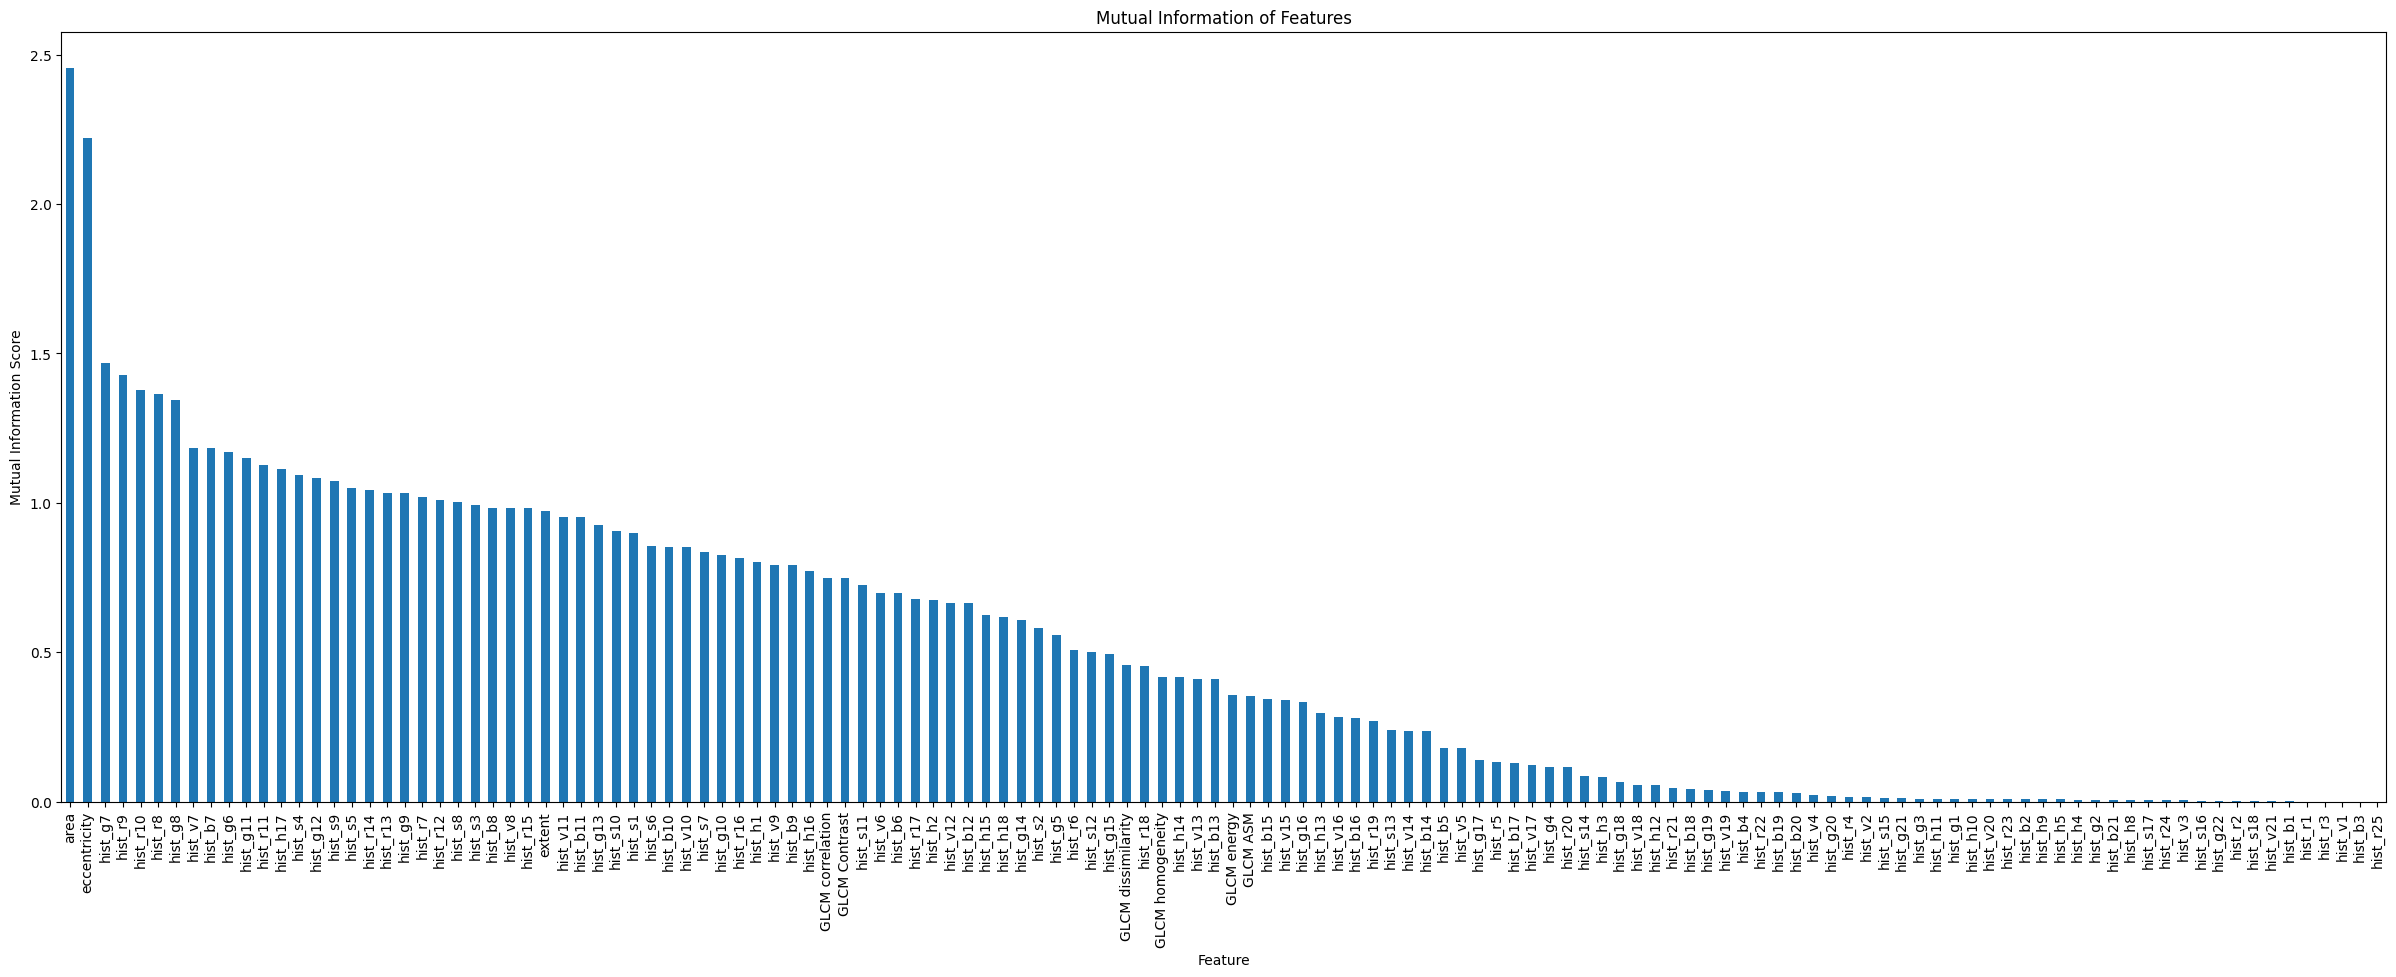

Features to drop based on MI threshold of 0.05:
9       hist_r1
10      hist_r2
11      hist_r3
12      hist_r4
29     hist_r21
30     hist_r22
31     hist_r23
32     hist_r24
33     hist_r25
34      hist_g1
35      hist_g2
36      hist_g3
52     hist_g19
53     hist_g20
54     hist_g21
55     hist_g22
56      hist_b1
57      hist_b2
58      hist_b3
59      hist_b4
73     hist_b18
74     hist_b19
75     hist_b20
76     hist_b21
80      hist_h4
81      hist_h5
82      hist_h8
83      hist_h9
84     hist_h10
85     hist_h11
107    hist_s15
108    hist_s16
109    hist_s17
110    hist_s18
111     hist_v1
112     hist_v2
113     hist_v3
114     hist_v4
129    hist_v19
130    hist_v20
131    hist_v21
Name: Feature, dtype: object


In [10]:
# ATTRIBUTE SELECTION (Mutual information)

X = attr_df.copy()
y = train_ds['Weight']

from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(X, y)

mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Info': mi})
print(mi_df.sort_values(by='Mutual Info', ascending=False))

# Plot MI scores to visualize
plt.figure(figsize=(30, 10))
mi_df.sort_values(by='Mutual Info', ascending=False).plot(figsize=(30, 10),kind='bar', x='Feature', y='Mutual Info', legend=False)
plt.title('Mutual Information of Features')
plt.ylabel('Mutual Information Score')
plt.show()

# Set a custom threshold (for example, 0.05)
threshold = 0.05
low_mi_features = mi_df[mi_df['Mutual Info'] < threshold]['Feature']
print("Features to drop based on MI threshold of 0.05:")
print(low_mi_features)

df = X.drop(columns=low_mi_features)

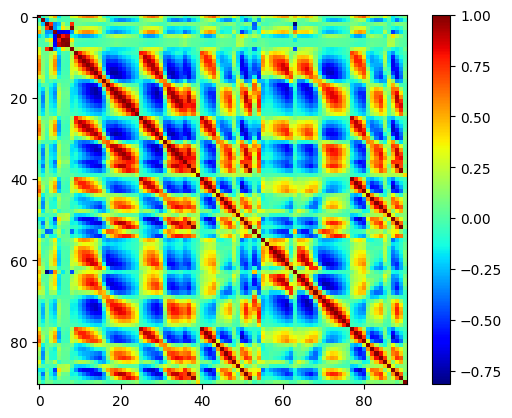

[ 7  8 12 20 21 26 27 28 29 32 33 34 35 37 40 41 51 52 60 65 66 77 78 79
 80 81 82 83 84 85 86 87 88 89]
Características correladas:  Index(['GLCM energy', 'GLCM correlation', 'hist_r8', 'hist_r16', 'hist_r17',
       'hist_g5', 'hist_g6', 'hist_g7', 'hist_g8', 'hist_g11', 'hist_g12',
       'hist_g13', 'hist_g14', 'hist_g16', 'hist_b5', 'hist_b6', 'hist_b16',
       'hist_b17', 'hist_h16', 'hist_s3', 'hist_s4', 'hist_v5', 'hist_v6',
       'hist_v7', 'hist_v8', 'hist_v9', 'hist_v10', 'hist_v11', 'hist_v12',
       'hist_v13', 'hist_v14', 'hist_v15', 'hist_v16', 'hist_v17'],
      dtype='object')
Características NO correladas:  ['GLCM ASM' 'GLCM Contrast' 'GLCM dissimilarity' 'GLCM homogeneity' 'area'
 'eccentricity' 'extent' 'hist_b10' 'hist_b11' 'hist_b12' 'hist_b13'
 'hist_b14' 'hist_b15' 'hist_b7' 'hist_b8' 'hist_b9' 'hist_g10' 'hist_g15'
 'hist_g17' 'hist_g18' 'hist_g4' 'hist_g9' 'hist_h1' 'hist_h12' 'hist_h13'
 'hist_h14' 'hist_h15' 'hist_h17' 'hist_h18' 'hist_h2' 'hist_h3'
 'his

In [11]:
# Correlation analysis
R = np.corrcoef(df.transpose())

import matplotlib.pyplot as plt
plt.imshow(R, cmap='jet')
plt.colorbar()
plt.show()

# set threshold
th_cor = 0.9

idx = abs(R)>th_cor
mat_tri_sup = np.triu(idx,1)
# print(mat_tri_sup.astype('uint8'))

row, col = np.where(mat_tri_sup==True)
id_corr = np.unique(col)
print(id_corr)

print('Características correladas: ', df.columns[id_corr])
print('Características NO correladas: ', np.setdiff1d(df.columns,  df.columns[id_corr]))

X_final = np.delete(df, id_corr, axis=1)
X_final = pd.DataFrame(df, columns=df.columns)

In [12]:
print(X_final.columns)
print(X_final.shape)

Index(['area', 'eccentricity', 'extent', 'GLCM Contrast', 'GLCM dissimilarity',
       'GLCM homogeneity', 'GLCM ASM', 'GLCM energy', 'GLCM correlation',
       'hist_r5', 'hist_r6', 'hist_r7', 'hist_r8', 'hist_r9', 'hist_r10',
       'hist_r11', 'hist_r12', 'hist_r13', 'hist_r14', 'hist_r15', 'hist_r16',
       'hist_r17', 'hist_r18', 'hist_r19', 'hist_r20', 'hist_g4', 'hist_g5',
       'hist_g6', 'hist_g7', 'hist_g8', 'hist_g9', 'hist_g10', 'hist_g11',
       'hist_g12', 'hist_g13', 'hist_g14', 'hist_g15', 'hist_g16', 'hist_g17',
       'hist_g18', 'hist_b5', 'hist_b6', 'hist_b7', 'hist_b8', 'hist_b9',
       'hist_b10', 'hist_b11', 'hist_b12', 'hist_b13', 'hist_b14', 'hist_b15',
       'hist_b16', 'hist_b17', 'hist_h1', 'hist_h2', 'hist_h3', 'hist_h12',
       'hist_h13', 'hist_h14', 'hist_h15', 'hist_h16', 'hist_h17', 'hist_h18',
       'hist_s1', 'hist_s2', 'hist_s3', 'hist_s4', 'hist_s5', 'hist_s6',
       'hist_s7', 'hist_s8', 'hist_s9', 'hist_s10', 'hist_s11', 'hist_s12',
     

In [13]:
df.to_csv("attributes_labeled.csv", sep=";")

In [16]:
# Standarize dataset

from sklearn.preprocessing import StandardScaler
import joblib

scaler = StandardScaler()
df_std = df.copy()
df_std = scaler.fit_transform(df)

df_std = pd.DataFrame(df_std, columns=df.columns)

# Save scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [17]:
df_std["Weight"] = train_ds["Weight"]
df_std.to_csv("attributes_std.csv")

In [18]:
print(df_std.columns)

Index(['area', 'eccentricity', 'extent', 'GLCM Contrast', 'GLCM dissimilarity',
       'GLCM homogeneity', 'GLCM ASM', 'GLCM energy', 'GLCM correlation',
       'hist_r5', 'hist_r6', 'hist_r7', 'hist_r8', 'hist_r9', 'hist_r10',
       'hist_r11', 'hist_r12', 'hist_r13', 'hist_r14', 'hist_r15', 'hist_r16',
       'hist_r17', 'hist_r18', 'hist_r19', 'hist_r20', 'hist_g4', 'hist_g5',
       'hist_g6', 'hist_g7', 'hist_g8', 'hist_g9', 'hist_g10', 'hist_g11',
       'hist_g12', 'hist_g13', 'hist_g14', 'hist_g15', 'hist_g16', 'hist_g17',
       'hist_g18', 'hist_b5', 'hist_b6', 'hist_b7', 'hist_b8', 'hist_b9',
       'hist_b10', 'hist_b11', 'hist_b12', 'hist_b13', 'hist_b14', 'hist_b15',
       'hist_b16', 'hist_b17', 'hist_h1', 'hist_h2', 'hist_h3', 'hist_h12',
       'hist_h13', 'hist_h14', 'hist_h15', 'hist_h16', 'hist_h17', 'hist_h18',
       'hist_s1', 'hist_s2', 'hist_s3', 'hist_s4', 'hist_s5', 'hist_s6',
       'hist_s7', 'hist_s8', 'hist_s9', 'hist_s10', 'hist_s11', 'hist_s12',
     